# Data Analyst Call Center Report
Scott Schmidt

Some important call center features to analyze are:
1. Call Volume and Trends: Analyze the call volume over time to identify patterns, peak hours, and trends for workload distribution and optimize staffing levels. Look for patterns in call volume across days, weeks, or months to allocate resources effectively.

2. Average Call Duration: Calculate the average duration of calls and identify any outliers or excessively long calls. This can provide insights into call complexity, customer issues, or potential areas for improvement in call handling processes.

3. Response Time: Evaluate the response time metrics, such as the average speed to answer calls or the average hold time. Analyze if there are any delays in answering calls and identify opportunities to reduce wait times and improve customer satisfaction.

4. Call Resolution Rate: Assess the rate at which calls are resolved on the first contact. Analyze the percentage of calls that require multiple interactions or escalations. This can indicate the effectiveness of your call center agents and the need for additional training or resources.

5. Customer Satisfaction: Gather customer feedback through surveys or post-call rating systems to measure customer satisfaction levels. Analyze customer satisfaction scores or comments to identify common pain points, areas for improvement, or successful customer interactions.

6. Call Reasons and Categories: Categorize and analyze the reasons for customer calls. This can help identify the most frequent issues or inquiries. Understanding the primary reasons for calls can guide process improvements, self-service initiatives, or training programs for call center agents.

7. Agent Performance: Evaluate individual agent performance metrics, such as call handling time, call resolution rate, customer satisfaction scores, or adherence to scripts/guidelines. Identify top-performing agents and areas where additional support or training may be needed.

8. Call Abandonment Rate: Monitor the rate at which customers abandon calls before reaching an agent. Analyze if there are any patterns or common reasons for call abandonment. This can highlight potential issues with wait times, IVR systems, or call routing.

9. Customer Segmentation: Segment customers based on various criteria such as demographics, call history, or customer value. Analyze the call patterns and needs of different customer segments to tailor your service offerings, provide personalized experiences, or identify areas for upselling/cross-selling.

10. Operational Efficiency: Evaluate metrics related to call center operations, such as average handle time, call transfer rate, or agent occupancy rate. Identify bottlenecks or inefficiencies in call routing, workflow processes, or technology systems that impact operational efficiency.

## Read Data

In [1]:
import numpy as np 
import pandas as pd 
file=r'/kaggle/input/call-center-data/Call Center Data.csv'

In [2]:
df=pd.read_csv(file)
print(len(df))
df.head(10)

1251


,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds)
0,1,217,204,94.01%,13,0:00:17,0:02:14,0:02:45,76.28%
1,2,200,182,91.00%,18,0:00:20,0:02:22,0:06:55,72.73%
2,3,216,198,91.67%,18,0:00:18,0:02:38,0:03:50,74.30%
3,4,155,145,93.55%,10,0:00:15,0:02:29,0:03:12,79.61%
4,5,37,37,100.00%,0,0:00:03,0:02:06,0:00:35,97.30%
5,6,315,304,96.51%,11,0:00:18,0:01:35,0:02:37,77.17%
6,7,252,244,96.83%,8,0:00:13,0:01:50,0:02:02,82.00%
7,8,213,205,96.24%,8,0:00:10,0:02:10,0:03:22,88.10%
8,9,219,200,91.32%,19,0:00:15,0:02:18,0:06:12,79.45%
9,10,371,348,93.80%,23,0:00:19,0:01:40,0:03:29,73.63%


## Missing Values and Column Types
There are luckily no missing values that we need to worry about.

In [3]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

Index                         0.0
Incoming Calls                0.0
Answered Calls                0.0
Answer Rate                   0.0
Abandoned Calls               0.0
Answer Speed (AVG)            0.0
Talk Duration (AVG)           0.0
Waiting Time (AVG)            0.0
Service Level (20 Seconds)    0.0
dtype: float64

In [4]:
df.dtypes

Index                          int64
Incoming Calls                 int64
Answered Calls                 int64
Answer Rate                   object
Abandoned Calls                int64
Answer Speed (AVG)            object
Talk Duration (AVG)           object
Waiting Time (AVG)            object
Service Level (20 Seconds)    object
dtype: object

In [5]:
# Change the wait time which in object time form into minutes:
df['Wait Time Minutes(AVG)'] = df['Waiting Time (AVG)'].apply(lambda x: sum(int(i) * 60 ** index for index, i in enumerate(x.split(':')[::-1])) // 60)
df['Talk Duration Minutes(AVG)'] = df['Talk Duration (AVG)'].apply(lambda x: sum(int(i) * 60 ** index for index, i in enumerate(x.split(':')[::-1])) // 60)

In [6]:
# Change these two objects as a percent into an int value:
df['Answer Rate'] = df['Answer Rate'].str.rstrip('%').astype(float)
df['Service Level (20 Seconds)'] = df['Service Level (20 Seconds)'].str.rstrip('%').astype(float)

## Top Abandon Calls
Using PowerBI/Tablaeu, we can clearly see a trend in service levels and abandoned calls.
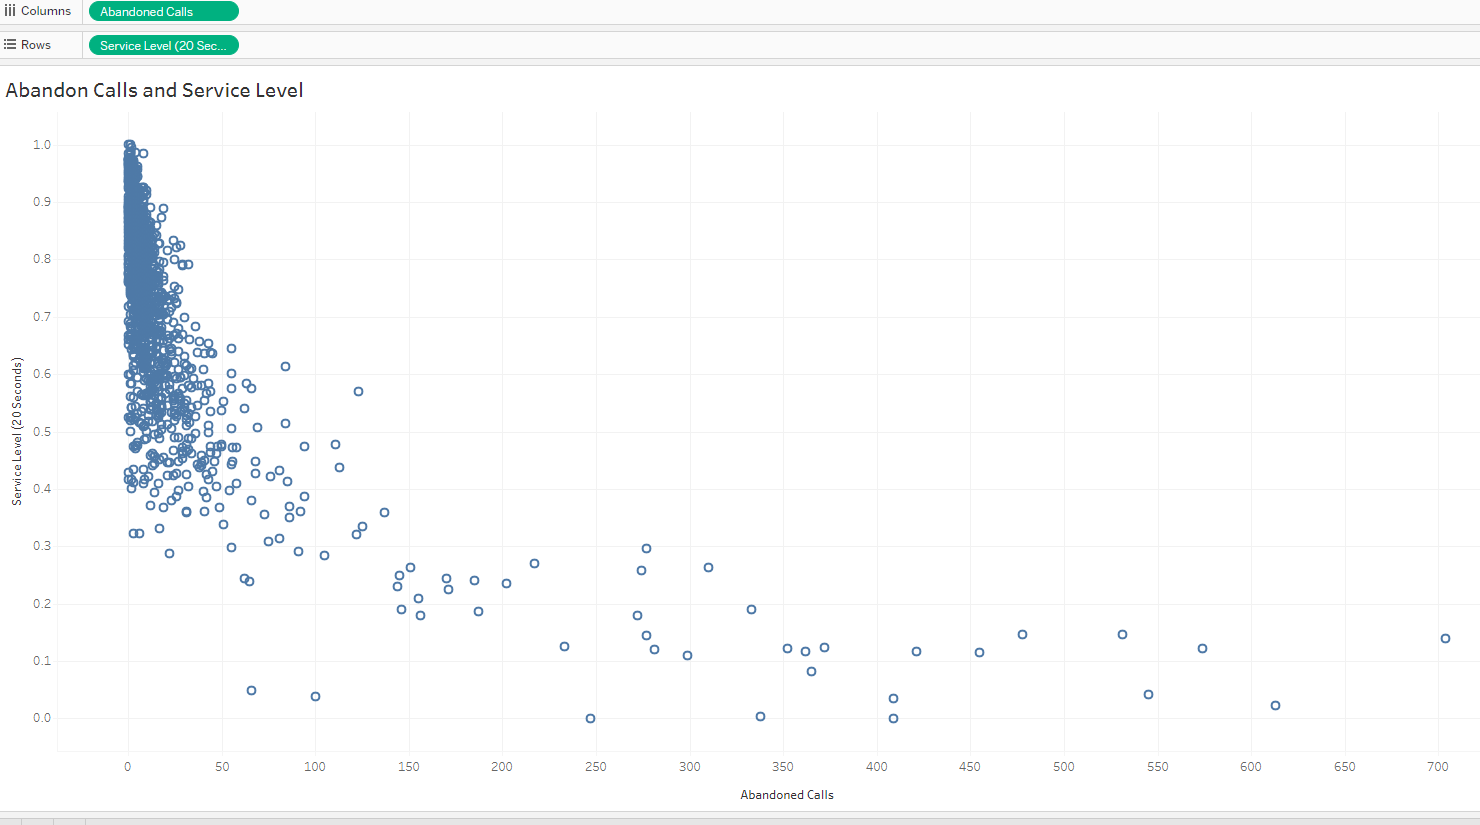
Lots of investiation needs to be done on these top 25 index with very high abandon percentages. 
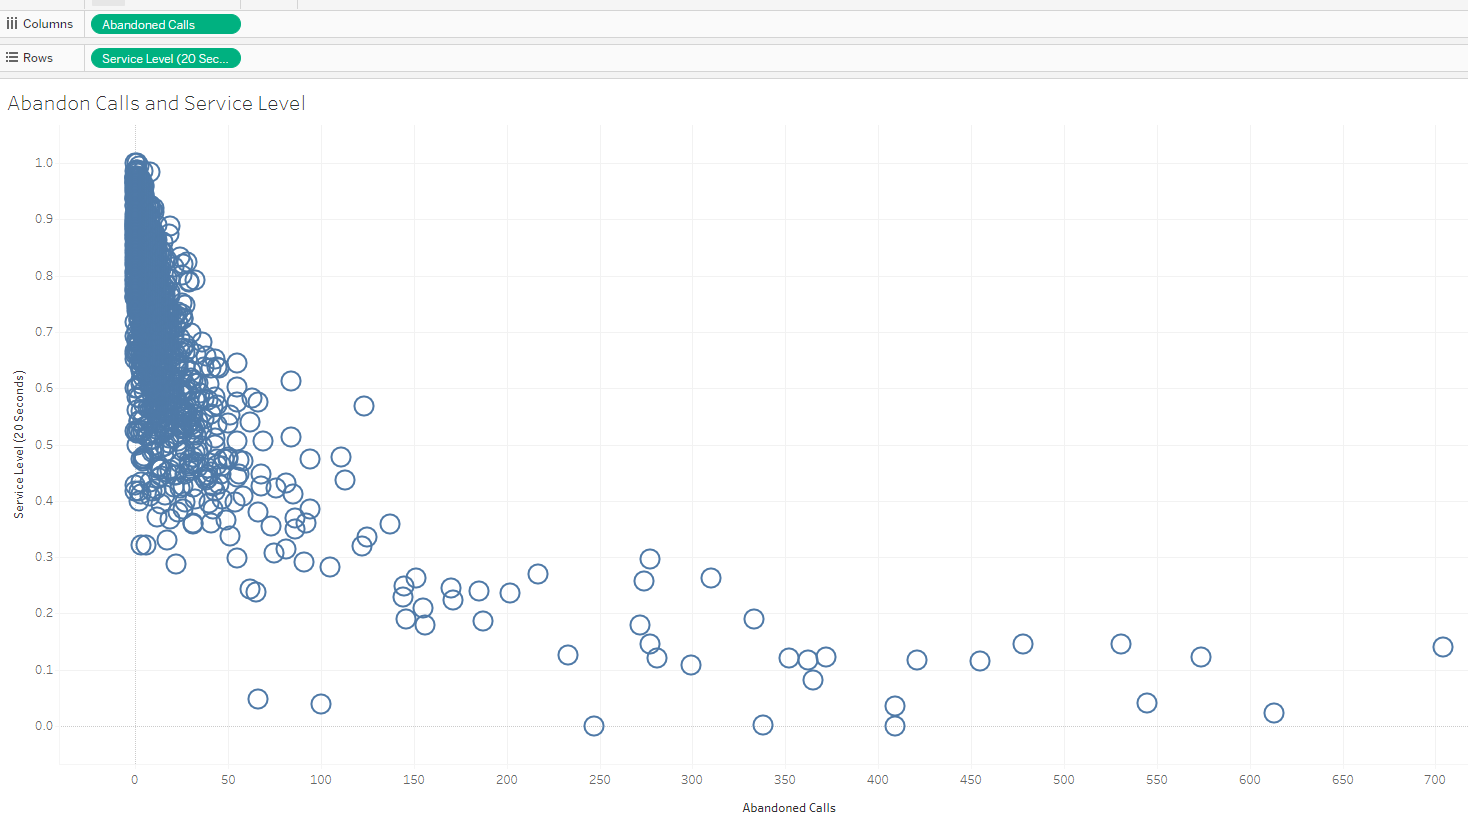

In [7]:
# Transform into a percent:
df['Abandoned_perc']=df['Abandoned Calls']/df['Answered Calls']
df['Abandoned_perc']=df['Abandoned_perc'].round(4)
abandonDF=df[['Index', 'Abandoned_perc', 'Waiting Time (AVG)']].sort_values(by=['Abandoned_perc'], ascending=False)
abandonDF.head(25)

,Index,Abandoned_perc,Waiting Time (AVG)
693,694,3.5259,0:22:56
692,693,3.2816,0:15:38
691,692,3.1667,0:17:27
694,695,2.0348,0:19:15
842,843,1.3532,0:22:37
840,841,1.2004,0:13:24
684,685,1.1765,0:11:01
835,836,1.0941,0:16:25
798,799,1.0000,0:12:18
799,800,0.9946,0:16:38


In [8]:
corr=df['Abandoned_perc'].corr(df['Wait Time Minutes(AVG)'])
print(corr.round(4), " correlation between wait time and abandon calls")

0.6406  correlation between wait time and abandon calls


### Bottle Necks
Below are three index that seem to have long wait times.

In [9]:
df.iloc[[694]]

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds),Wait Time Minutes(AVG),Talk Duration Minutes(AVG),Abandoned_perc
694,695,610,201,32.95,409,0:03:13,0:02:52,0:19:15,3.52,19,2,2.0348


In [10]:
df.iloc[[693]]

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds),Wait Time Minutes(AVG),Talk Duration Minutes(AVG),Abandoned_perc
693,694,525,116,22.1,409,0:05:08,0:03:08,0:22:56,0.0,22,3,3.5259


In [11]:
df.iloc[[692]]

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds),Wait Time Minutes(AVG),Talk Duration Minutes(AVG),Abandoned_perc
692,693,441,103,23.36,338,0:04:04,0:02:43,0:15:38,0.23,15,2,3.2816


## Outlier

In [12]:
# Calculate Z-scores
z_scores = np.abs((df['Talk Duration Minutes(AVG)'] - df['Talk Duration Minutes(AVG)'].mean()) / df['Talk Duration Minutes(AVG)'].std())

# Set a threshold (e.g., 2 or 3 standard deviations)
threshold = 3

# Detect outliers
outliers = df[z_scores > threshold]
outliers

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds),Wait Time Minutes(AVG),Talk Duration Minutes(AVG),Abandoned_perc
184,185,483,451,93.37,32,0:00:16,0:00:57,0:08:45,79.20,8,0,0.0710
571,572,18,17,94.44,1,0:00:55,0:04:01,0:05:46,50.00,5,4,0.0588
800,801,582,301,51.72,281,0:02:41,0:04:13,0:21:42,12.08,21,4,0.9336
802,803,116,106,91.38,10,0:00:34,0:04:23,0:04:44,62.93,4,4,0.0943
803,804,533,300,56.29,233,0:02:12,0:04:03,0:12:24,12.55,12,4,0.7767
972,973,7,6,85.71,1,0:00:03,0:04:48,0:00:31,85.71,0,4,0.1667
